In [1]:
# load credentials from environment variables
%load_ext dotenv
%dotenv

# util
import numpy as np

# date & time
from datetime import timezone, date, datetime
from dateutil.relativedelta import relativedelta as rdelta
from dateutil.rrule import rrule, MONTHLY

# output processing and plotting
import io
import tarfile
import rasterio
from rasterio.plot import show
from matplotlib import pyplot

# Oauth
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session

## Get authorization token

In [2]:
# Your client credentials
client_id = %env SH_CLIENT_ID
client_secret = %env SH_CLIENT_SECRET

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

token = oauth.fetch_token(token_url='https://services.sentinel-hub.com/oauth/token',
                          client_id=client_id, client_secret=client_secret)

resp = oauth.get("https://services.sentinel-hub.com/oauth/tokeninfo")

## Configure request (evalscript)

Enter start and end date, input bands, indices. The resulting files will have two time intervals per month, being split at `day_of_new_interval`.

In [3]:
startdate = date(2018,7,1) # Y,M,D
enddate = date(2018,9,15)  # Y,M,D

input_bands = ["B03",
               "B04",
               "B05",
               "B08"]
indices = ['NDVI',
           "NDWI",
           "CVI"]

bucket_name = "eox-masterdatacube"

day_of_new_interval = 16 # leave this unchanged in most of the cases

### Calculate parameters

In [4]:
starttime = datetime(*startdate.timetuple()[:6])
endtime = datetime(*enddate.timetuple()[:6])

d=day_of_new_interval
dates = list(rrule(MONTHLY, dtstart=startdate, until=enddate, bymonthday=[1,d-1,d,31]))
dates = [starttime] + dates if dates[0] != starttime else dates
dates = dates + [endtime] if dates[-1] != endtime else dates

starts = dates[0::2]
starts = [int(d.timestamp()) for d in starts] # timestamps for arithmetic
ends   = [d+rdelta(hour=23, minute=59, second=59) for d in dates[1::2]]
ends   = [int(d.timestamp()) for d in ends]   # timestamps for arithmetic
avg_times = list(np.mean(list(zip(starts,ends)), axis=1))
avg_times = [datetime.utcfromtimestamp(a) for a in avg_times]
avg_times = [dt.isoformat() for dt in avg_times]

In [5]:
masks = ["SCL", "dataMask"] # SCL ... Scene Classification Layer

output_bands = input_bands + indices
output_array =  [ { 'id': "\"" + ob + "\"", 'bands': len(avg_times), "sampleType": "SampleType.UINT16"} for ob in output_bands ]
for oa in output_array:
    if oa["id"] == '"CVI"':
        oa["sampleType"] = "SampleType.FLOAT32"
output_array = str(output_array).replace("'", '')

int_bands = '{' + ','.join([f'{ib}: []' for ib in input_bands]) + '}'
results_object = '{' + ','.join([f'{ob}: []' for ob in output_bands]) + '}'
debug_results = '{' + ','.join([f"{output_bands[i]}: [{i+1}]" for i in range(len(output_bands))]) + '}'
responses = [{"identifier": ob,"format": {"type": "image/tiff"}} for ob in output_bands]
output_array

'[{id: "B03", bands: 5, sampleType: SampleType.UINT16}, {id: "B04", bands: 5, sampleType: SampleType.UINT16}, {id: "B05", bands: 5, sampleType: SampleType.UINT16}, {id: "B08", bands: 5, sampleType: SampleType.UINT16}, {id: "NDVI", bands: 5, sampleType: SampleType.UINT16}, {id: "NDWI", bands: 5, sampleType: SampleType.UINT16}, {id: "CVI", bands: 5, sampleType: SampleType.FLOAT32}]'

### Evalscript & Payload

In [6]:
with open('evalscript.js', 'r') as file:
    evalscript = file.read()
    
evalscript = evalscript.format(
    bands              =str(input_bands+masks),
    output_array       =output_array,
    results_object     =results_object,
    day_of_new_interval=day_of_new_interval,
    enddate_unix       =datetime(*enddate.timetuple()[:3],23,59,59).timestamp()*1000,
    debug_results      =debug_results,
    int_bands          =int_bands,
    indices            =indices,
    avg_times          =avg_times
)

In [7]:
payload = {
  "input": {
    "bounds": {
      "properties": {
        "crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"
      },
      "bbox": [16.446445736463346, 47.680841561177864, 16.49776618971013, 47.72587417451863]
    },
    "data": [
      {
        "type": "S2L2A",
        "dataFilter": {
          "timeRange": {
            "from": starttime.isoformat()+'Z',
            "to": endtime.isoformat() + 'Z'
          },
          "mosaickingOrder": "mostRecent",
          "maxCloudCoverage": 100,
          "previewMode": "DETAIL"
        }
      }
    ]
  },
  "output": {
    "width": 512,
    "height": 512,
    "responses": [*responses,
      {
        "identifier": "userdata",
        "format": {
          "type": "application/json"
        }
      }
    ]
  },
  "evalscript": evalscript,
  "tilingGridId": 0,
  "bucketName": "eox-sentinelhub-batch",
  "resolution": 40.0,
  "description": "Test Loipersbach"
}

headers = {
  'Accept': 'application/tar'
}

## Send request

In [8]:
def generate_url(request_id="", action=""):
    url = 'https://services.sentinel-hub.com/api/v1/process/'
    if request_id:
        url += f'{request_id}/'
        if action:
            url += f'{action}'
    return url

In [9]:
%%time
response = oauth.request("POST", generate_url(), headers=headers, json = payload)

if response.status_code != 200:
    print(response.json()['error'])

CPU times: user 65.9 ms, sys: 25.3 ms, total: 91.1 ms
Wall time: 21.9 s


## View output

-rw-r--r-- 0/0    1566393 2020-04-21 10:17:07 B03.tif 
-rw-r--r-- 0/0    1582635 2020-04-21 10:17:07 B04.tif 
-rw-r--r-- 0/0     519543 2020-04-21 10:17:08 B05.tif 
-rw-r--r-- 0/0    1703162 2020-04-21 10:17:08 B08.tif 
-rw-r--r-- 0/0    1914554 2020-04-21 10:17:08 NDVI.tif 
-rw-r--r-- 0/0    1900549 2020-04-21 10:17:08 NDWI.tif 
-rw-r--r-- 0/0    3511906 2020-04-21 10:17:08 CVI.tif 
-rw-r--r-- 0/0       2536 2020-04-21 10:17:08 userdata.json 


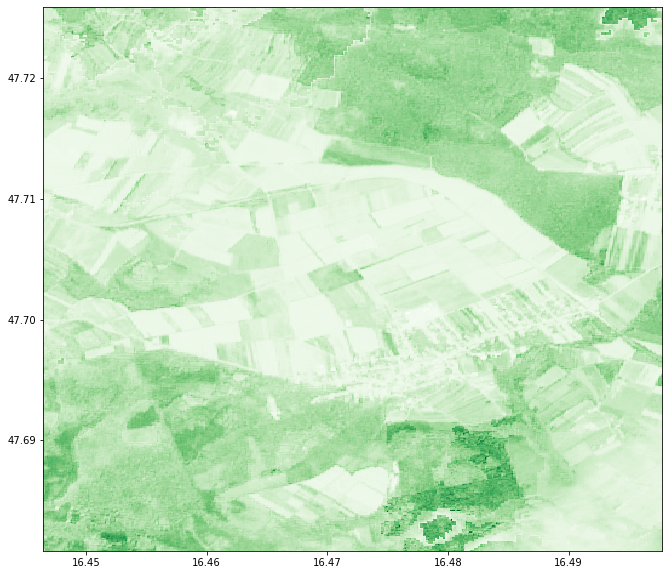

{
  "metadata": [
    {
      "date": "Thu Sep 13 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 0
    },
    {
      "date": "Mon Sep 10 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 1
    },
    {
      "date": "Sat Sep 08 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 2
    },
    {
      "date": "Wed Sep 05 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 3
    },
    {
      "date": "Mon Sep 03 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 4
    },
    {
      "date": "Fri Aug 31 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 5
    },
    {
      "date": "Wed Aug 29 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 6
    },
    {
      "date": "Sun Aug 26 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 7
    },
    {
      "date": "Fri Aug 24 2018 00:00:00 GMT+0000 (UTC)",
      "bandBuffers": [],
      "idx": 8

In [10]:
file = io.BytesIO(response.content)
tar = tarfile.open(fileobj=file, mode="r")
tar.list()
tar.extractall('../testing/')#('B04.tif', '../testing/')

with rasterio.open(tar.extractfile('CVI.tif')) as tif:
    pyplot.figure(figsize=(16,10))
    show((tif,1), transform=tif.transform, cmap='Greens')

import json
with open('../testing/userdata.json') as userdata:
    parsed = json.load(userdata)
    print(json.dumps(parsed, indent=2))